# **GENES-SMD and GENES-PLANTS**

# **IMPORTS**

In [ ]:
!pip3 install matplotlib

In [ ]:
import re
import requests
import pandas as pd
import ast

import matplotlib.pyplot as plt
import networkx as nx

from google.colab import drive
from bs4 import BeautifulSoup

In [ ]:
# Authentication to Read and Upload Files
drive.mount("/content/drive")

Mounted at /content/drive


# **CONSTANT VARIABLES**

In [ ]:
# HI 193.1 (Group 6) - Final Paper [Drive] Folder
GDRIVE = '/content/drive/My Drive/HI 193.1 (Group 6) - Final Paper [Drive]/'

# Columns of the CSV files
DRUG_DETAILS = ["Generic Name", "Synonyms", "Genes"]
PLANT_DETAILS = ["Scientific Name", "Common Name", "Phytochemicals"]

# Link to CSV files
DRUGBANK_CSV = GDRIVE + 'drug-bank-data.csv'
DRDUKES_CSV = GDRIVE + 'dr-dukes-data.csv'

GENES_SMD_DATA_CSV = GDRIVE + 'genes-smd-data.csv'
PLANTS_SMD_DATA_CSV = GDRIVE + 'plants-smd-data.csv'
GENE_SMD_TABLE_CSV = GDRIVE + 'gene-smd-table.csv'
GENE_PLANT_TABLE_CSV = GDRIVE + 'gene-plant-table.csv'

# DrugBank Links for processing
DRUGBANK_URL = 'https://go.drugbank.com/'
DRUGBANK_DRUGS_URL = 'https://go.drugbank.com/drugs'

# Dr. Dukes Links for processing
DRDUKES_URL = 'https://phytochem.nal.usda.gov/'
DRDUKES_PLANTS_URL = 'https://phytochem.nal.usda.gov/phytochem/plants/show/'
DRDUKES_PHYTOCHEMICALS_URL = 'https://phytochem.nal.usda.gov/phytochem/plants/plantsFarmacyList/'

# **WEBSCRAPPING FUNCTIONS**

## DrugBank

In [ ]:
# Get Drug Bank Data
def GetDrugBankData():
  data = pd.DataFrame(columns=DRUG_DETAILS)
  url = DRUGBANK_DRUGS_URL

  while url:
    # Request HTML of Page
    r = requests.get(url)

    # Parse Request of Page
    soup = BeautifulSoup(r.text ,"lxml")

    # Obtain Anchor Element of Links
    links = soup.select('strong a')

    # Get Drug Details Per Drug
    for link in links:
      data = data.append(GetDrugDetails(DRUGBANK_URL + link['href']), ignore_index=True)
    
    # Check if next page exists
    url = soup.findAll('a', {'class': 'page-link', 'rel': 'next'})
    if url:
      url = DRUGBANK_URL + url[0].get('href')
    else:
      break
      
  return data

# Get Drug Details Based on URL
def GetDrugDetails(url):
  # Request HTML of Drug Details Page
  r = requests.get(url)

  # Parse Request of Drug Details Page
  soup = BeautifulSoup(r.text ,"lxml")

  # Get Drug Detail Labels
  dts = soup.findAll('dt')

  # Get Drug Detail Values
  dds = soup.findAll('dd')

  # Create a dictionary w/ labels mapping to its values
  curr = {}

  # Get Generic Name
  for dt, dd in zip(dts, dds):
    if dt.text == "Generic Name":
      curr[dt.text] = dd.text

  # Get Synonyms
  synonyms = []
  syn_dd = soup.find("dt", {"id": "synonyms"}).findNext('dd')
  if syn_dd.ul:
    for li in syn_dd.findAll('li'):
      synonyms.append(li.text)
  else:
    synonyms = "Not Available"
  
  curr["Synonyms"] = synonyms

  # Get Genes
  genes = []
  gene_dts = soup.findAll("dt", {"id": "gene-name"})
  if gene_dts:
    for gene_dt in gene_dts:
      gene_dd = gene_dt.findNext('dd')
      if gene_dd.text != "Not Available":
        genes.append(gene_dd.text)
    if not genes:
      genes = "Not Available"
  else:
    genes = "Not Available"

  curr["Genes"] = genes

  return curr


## Dr.  Dukes Phytochemical and Ethnobotanical Databases

In [ ]:
# Get Dr Dukes Data
def GetDrDukesData():
  data = pd.DataFrame(columns = PLANT_DETAILS)
  
  plantNo = 1
  url = DRDUKES_PLANTS_URL + str(plantNo)

  while url:
    # Request HTML of Page
    r = requests.get(url)

    # Parse Request of Page
    soup = BeautifulSoup(r.text, "lxml")

    # Page
    page = soup.find("h1", {"class": "entityHeader"})

    if page:
      sn = soup.find("h1", {"class": "entityHeader"})
      sn.a.decompose()
      sn.span.decompose()
      sn = FixWhiteSpace(sn.text)

      # Common Name
      cn = "Not Available"
      cnHeader = soup.find("h2", text="Common name(s)")
      if cnHeader:
        cnHeader = cnHeader.find_parent("li")
        cnHeader.h2.decompose()
        cn = FixWhiteSpace(cnHeader.text)

      # Get Phythochemicals of Current Plant
      phytochemicals = GetPlantDetails(plantNo)

      data = data.append({"Scientific Name": sn, "Common Name": cn, "Phytochemicals": phytochemicals}, ignore_index=True)
      
      plantNo += 1
      url = DRDUKES_PLANTS_URL + str(plantNo)
    else:
      break

  return data

# Get Plant Details based on current page
def GetPlantDetails(plantNo):

  phytochemicals = []
  offset = 0
  url = DRDUKES_PHYTOCHEMICALS_URL + str(plantNo) + "?offset=" + str(offset) + "&max=20"
  
  while url:
    # Request HTML of Plant Details Page
    r = requests.get(url)

    # Parse Request of Plant Details Page
    soup = BeautifulSoup(r.text, "lxml")

    # Check if Plant Details Subpage contains Phythochemicals
    pcs = soup.find_all("a", {"title": "Click to view details for this Chemical"})

    if pcs:
      # print('\n [PLANT] {0} [PC PAGE] {1} \n'.format(plantNo, int(offset/20) + 1))
      for pc in pcs:
        phytochemicals.append(FixWhiteSpace(pc.text))
      offset += 20
      url = DRDUKES_PHYTOCHEMICALS_URL + str(plantNo) + "?offset=" + str(offset) + "&max=20"
    else:
      break
  
  if not phytochemicals:
    phytochemicals = "Not Available"

  return phytochemicals

# **HELPER FUNCTIONS**

In [ ]:
def FixWhiteSpace(input):
  return ' '.join(input.strip().split())

def RemoveDuplicates(input):
  return list(dict.fromkeys(input))

# Remove columns and rows with zeros
def SimplifyTable(data):
  table = data.copy()
  table = table.loc[(table!=0).any(1)]
  table = table.loc[:,(table!= 0).any(axis=0)]
  return table

# Remove Unwanted Rows 
def RemoveRowWithoutValue(data, columnName, value):
  table = data.copy()
  table.drop(table.loc[table[columnName] == value].index, inplace=True)
  return table

# Convert Columns Containing String of Lists into Lists of Strings
def FixStringListColumn(data, columnName):
  table = data.copy()
  for index, rows in table.iterrows():
    rows[columnName] = ast.literal_eval(rows[columnName])
  return table

# Bold printing
def PrintBold(input):
  print("\033[1m " + input + " \033[0m")

#**MAIN FUNCTIONS**

In [ ]:
def GetPlantsWithSMD(csv, smdsynonyms):
  data = pd.DataFrame(columns = PLANT_DETAILS)

  # Iterate over Plants
  for index, p in csv.iterrows():

      # Obtain plant and remove non-smd phytochemicals
      pcList = ast.literal_eval(p["Phytochemicals"])
      pcList = RemoveDuplicates(pcList)
      pcList = set(smdsynonyms).intersection(set(pcList))

      if pcList:
        data = data.append( {"Scientific Name": p["Scientific Name"], "Common Name": p["Common Name"], "Phytochemicals": pcList}, ignore_index = True)
  return data

In [ ]:
# Change Dr Dukes Phytochemical Column to SMD Column
def RemoveNonSMDPhytochemicals(dbData, ddData):
  table = ddData.copy()
  smdsynList = []

  # Get All SMD Generic Names
  smdsynList = list(set(smdsynList) | set(dbData["Generic Name"]))

  # Get All SMD Common Names
  for row in dbData["Synonyms"]:
    if row != "Not Available":
      syn = ast.literal_eval(row)
      smdsynList = list(set(smdsynList) | set(syn))

  # Capitalize SMD-Synonym List for comparison
  smdsynList = [smdsyn.upper() for smdsyn in smdsynList]
  
  # Change Phytochemical Column to SMD column (Remove unwanted phytochemicals)
  for index, row in table.iterrows():
    smd = []
    if row["Phytochemicals"] != "Not Available":
      pcs = ast.literal_eval(row["Phytochemicals"])
      smd = list(set(smdsynList).intersection(set(pcs)))
      if smd:
        row["Phytochemicals"] = smd
      else:
        row["Phytochemicals"] = "Not Available"
  
  table.rename(columns = {"Phytochemicals": "SMDs"}, inplace = True)

  return table

# Remove Non-plant SMDs
def RemoveNonPlantSMD(genesSMDData, plantsSMDData):
  table = genesSMDData.copy()

  plantSMDs = []

  # Obtain All SMDs found in plants
  for index, row in plantsSMDData.iterrows():
    plantSMDs = list(set(row["SMDs"]) | set(plantSMDs))

  # Delete SMDs that are not needed by plants
  for index, row in table.iterrows():
    if row["Generic Name"].upper() not in plantSMDs:
      row["Generic Name"] = "Not Needed"
    else:
      row["Generic Name"] = row["Generic Name"].upper()
      row["Genes"] = ast.literal_eval(row["Genes"])

  table = RemoveRowWithoutValue(table, "Generic Name", "Not Needed")
  
  return table

def FilterPlantsOnUpdatedSMD(genesSMDData, plantsSMDData):
  table = plantsSMDData.copy()

  smdsynList = []

  # Add SMD Names
  smdsynList = list( set(genesSMDData["Generic Name"]) | set(smdsynList) )

  # Add Common Names
  for row in genesSMDData["Synonyms"]:
    if row != "Not Available":
      syn = ast.literal_eval(row)
      smdsynList = list(set(smdsynList) | set(syn))

  # Capitalize SMD-Synonym List for comparison
  smdsynList = [smdsyn.upper() for smdsyn in smdsynList]

  # Remove SMDs that have no genes
  for index, row in table.iterrows():
    smd = []
    
    smd = list(set(smdsynList).intersection(set(row["SMDs"])))
    if smd:
      row["SMDs"] = smd
    else:
      row["SMDs"] = "Not Available"

  return table

In [ ]:
# Create Gene-SMD Table
def CreateGeneSMDTable(genesSMDData):
  genes = []
  smd = []

  # Initialize Table
  for index, row in genesSMDData.iterrows():
    genes = list(set(genes) | set(row["Genes"]))

  smd = list(set(genesSMDData["Generic Name"]) | set(smd))

  table = pd.DataFrame(0, index = genes, columns = smd)

  # Fill-up Table
  for index, row in genesSMDData.iterrows():    
    for gene in row["Genes"]:
      table[row["Generic Name"]][gene] += 1

  return table

def CreateGenePlantTable(genesSMDData, plantsSMDData):

  genes = []
  plants = []

  # Initialize Table
  for index, row in genesSMDData.iterrows():
    genes = list(set(row["Genes"]) | set(genes))

  plants = list(set(plantsSMDData["Scientific Name"]) | set(plants))

  table = pd.DataFrame(0, index = genes, columns = plants)

  smd = []
  smd = list(set(genesSMDData["Generic Name"]) | set(smd))

  # Fill-up Table
  for indexP, rowP in plantsSMDData.iterrows():
    smdsPerPlant = list(rowP["SMDs"])

    genes = []
    for indexG, rowG in genesSMDData.iterrows():

      smdsynList = []
      smdsynList.append(rowG["Generic Name"])
      if rowG["Synonyms"] != "Not Available":
        smdsynList = list(set(ast.literal_eval(rowG["Synonyms"])) | set(smdsynList))

      # Capitalize SMD-Synonym List for comparison
      smdsynList = [smdsyn.upper() for smdsyn in smdsynList]

      if set(smdsynList).intersection(set(smdsPerPlant)):
        genes = list(set(rowG["Genes"]) | set(genes))
    
    for indexTC, columnTC in table.iteritems():
      if indexTC == rowP["Scientific Name"]:
        for gene in genes:
          table[indexTC][gene] += 1

  return table  


# Create a Graph with Matrix Input
def CreateGraphFromMatrix(matrix):
  G = nx.Graph()

  for indexRow, row in matrix.iterrows():
    for indexCol, column in matrix.iteritems():
      if matrix[indexCol][indexRow] > 0:
        # G.add_edge(*(indexCol, indexRow))
        G.add_edge(indexCol, indexRow, weight = matrix[indexCol][indexRow])

  return G

# Draw Graph
def DrawGraph(graph):
  plt.figure(figsize = (12, 12))
  nx.draw(graph, with_labels = True)
  plt.show()

In [ ]:
# Get Degree Centrality
def GetDegreeCentrality(G, nodes):
  degCen = {}
  for node in nodes:
    degCen[node] = len(G.edges(node))
  return sorted(degCen.items(), key = lambda item: item[1], reverse = True)

# Get Weighted Degree Centrality
def GetWeightedDegreeCentrality(G, nodes):
  weightedDegCen = {}
  for node in nodes:
    wdSum = 0;
    for edge in G.edges(node):
      wdSum += G.get_edge_data(edge[0], edge[1])["weight"]
    weightedDegCen[node] = wdSum

  return sorted(weightedDegCen.items(), key = lambda item: item[1], reverse = True)

# View gene associations based from given graph
def DisplayAssociationsFromGene(graph, nameOfAssociateNodes, gene):
  endString = "" if len(graph.edges(gene)) <= 1 else "/s"
  PrintBold(gene + " is associated with " + str(len(graph.edges(gene))) + " " + nameOfAssociateNodes + endString)
  G = nx.Graph()
  for edge in graph.edges(gene):
    G.add_edge(*edge)
  DrawGraph(G)

# **UPDATE CSV**
EXECUTE ONLY WHEN CSV NEEDS TO BE UPDATED (~55 mins to run)


In [ ]:
# Update Drug Bank Data (~ 15 mins)
drugBankData = GetDrugBankData()

# Save Drug Bank Data to CSV
drugBankData.to_csv(DRUGBANK_CSV, index=False)

In [ ]:
# Update Dr Dukes Data (~ 43 mins)
drDukesData = GetDrDukesData()

drDukesData.to_csv(DRDUKES_CSV, index=False)

# **CODE**

In [ ]:
# Get SMD data from DrugBank CSV
drugBankData = pd.read_csv(DRUGBANK_CSV)
print(len(drugBankData))

# Get Plant Data from Dr. Dukes CSV
drDukesData = pd.read_csv(DRDUKES_CSV)
print(len(drDukesData))

2695
2376


In [ ]:
# FILTER (genes - smd - PLANTS)

# [1] Include Phytochemicals that are SMD
plantsSMDData = RemoveNonSMDPhytochemicals(drugBankData, drDukesData)

# [2] If plant has no smd, genes to plants cannot be mapped
plantsSMDData = RemoveRowWithoutValue(plantsSMDData, "SMDs", "Not Available")
print(len(plantsSMDData))

1228


In [ ]:
# FILTER (GENES - smd - plants)
# [1] If no genes, genes to plants cannot be mapped
genesSMDData = RemoveRowWithoutValue(drugBankData, "Genes", "Not Available")
print(len(genesSMDData))

# FILTER (genes - SMD - plants)

# [1] Include SMD that are found in plants
genesSMDData = RemoveNonPlantSMD(genesSMDData, plantsSMDData)
print(len(genesSMDData))

2052
120


In [ ]:
# FILTER (genes - smd - PLANTS)
# [1] Have to update since some genes have been deleted, thus plant cannot map out
plantsSMDData = FilterPlantsOnUpdatedSMD(genesSMDData, plantsSMDData)

# [2] If plant has no smd, genes to plants cannot be mapped
plantsSMDData = RemoveRowWithoutValue(plantsSMDData, "SMDs", "Not Available")
print(len(plantsSMDData))

1072


In [ ]:
# Save to CSV (Uncomment if want to update and view data)
genesSMDData.to_csv(GENES_SMD_DATA_CSV,index = False)
plantsSMDData.to_csv(PLANTS_SMD_DATA_CSV ,index = False)

In [ ]:
# Create Gene (Rows) - SMD (Columns) Table
geneSMDTable = CreateGeneSMDTable(genesSMDData)

# Create Gene (Rows) - Plants (Columns) Table
genePlantTable = CreateGenePlantTable(genesSMDData, plantsSMDData)

In [ ]:
# Save to CSV (Uncomment if want to update and view data)
geneSMDTable.to_csv(GENE_SMD_TABLE_CSV,index = True)
genePlantTable.to_csv(GENE_PLANT_TABLE_CSV ,index = True)

In [ ]:
# Create Gene - SMD Graph
geneSMDGraph = CreateGraphFromMatrix(geneSMDTable)

# Create Gene - Plants Graph
genePlantGraph = CreateGraphFromMatrix(genePlantTable)

In [ ]:
# Get Degree Centrality For All Genes
dcGeneSMD = GetDegreeCentrality(geneSMDGraph, geneSMDTable.index.values)
dcGenePlant = GetDegreeCentrality(genePlantGraph, genePlantTable.index.values)

In [ ]:
# Get WeightedDegree Centrality For All Genes
wdcGeneSMD = GetWeightedDegreeCentrality(geneSMDGraph, geneSMDTable.index.values)
wdcGenePlant = GetWeightedDegreeCentrality(genePlantGraph, genePlantTable.index.values)

# **RESULTS**

In [ ]:
# Display Webscrapped DrugBank Data Set
PrintBold("SMD Generic Name, Synonyms, and Genes CSV [DrugBank Data Set]")
print(genesSMDData)

print()

# Display Webscrapped Dr Dukes Data Set
PrintBold("Plant Scientific Name, Common Name, and SMDs CSV [DrugBank Data Set]")
print(plantsSMDData)

 SMD Generic Name, Synonyms, and Genes CSV [DrugBank Data Set] 
     Generic Name  ...                                              Genes
44        ADENINE  ...  [APRT, mtnN, ACACB, ACP1, PECR, mutY, ptd, SRP...
45      ADENOSINE  ...  [ADORA1, ADORA2A, ADORA2B, ADORA3, ADA, ADK, A...
51       AJMALINE  ...                                      [SCN5A, ORM1]
67      ALLANTOIN  ...                                         [SERPINA7]
126       AMMONIA  ...                                 [GLS2, GLUL, CPS1]
...           ...  ...                                                ...
2634  VINBLASTINE  ...  [TUBA1A, TUBB, TUBD1, TUBG1, TUBE1, JUN, CYP3A...
2635  VINCRISTINE  ...  [TUBB, TUBA4A, CYP3A5, CYP3A7, CYP3A4, ABCB1, ...
2661    YOHIMBINE  ...  [ADRA2A, ADRA2B, ADRA2C, HTR1A, HTR1B, HTR1D, ...
2673         ZINC  ...  [BDKRB1, MGMT, ALDOA, EEF1A1, ENO1, GAPDHS, NM...
2692  ZUCAPSAICIN  ...           [TRPV1, CYP1A2, CYP2C19, CYP2C9, CYP2E1]

[120 rows x 3 columns]

 Plant Scientific Name,

In [ ]:
# Display Gene (Rows) - SMD (Columns) Table
PrintBold("Gene (Rows) - SMD (Columns) Table")
print(geneSMDTable)

print()

# Display Gene (Rows) - Plants(Columns) Table
PrintBold("Gene (Rows) - Plants (Columns) Table")
print(genePlantTable)

 Gene (Rows) - SMD (Columns) Table 
        APOMORPHINE  NOSCAPINE  QUININE  ...  RESCINNAMINE  ESTRONE  MANNITOL
SIVA1             0          0        0  ...             0        0         0
CYB5A             0          0        0  ...             0        0         0
PPIA              0          0        0  ...             0        0         0
bgl3              0          0        0  ...             0        0         0
cobT              0          0        0  ...             0        0         0
...             ...        ...      ...  ...           ...      ...       ...
AGXT2             0          0        0  ...             0        0         0
SLC5A6            0          0        0  ...             0        0         0
ASPA              0          0        0  ...             0        0         0
GLDC              0          0        0  ...             0        0         0
sacB              0          0        0  ...             0        0         0

[846 rows x 120 columns]

 

In [ ]:
# View Graphs (Graphs are randomly drawn, sometimes not centered and is off from display)
PrintBold("Gene-SMD Graph")
DrawGraph(geneSMDGraph)

 Gene-Plant Graph 


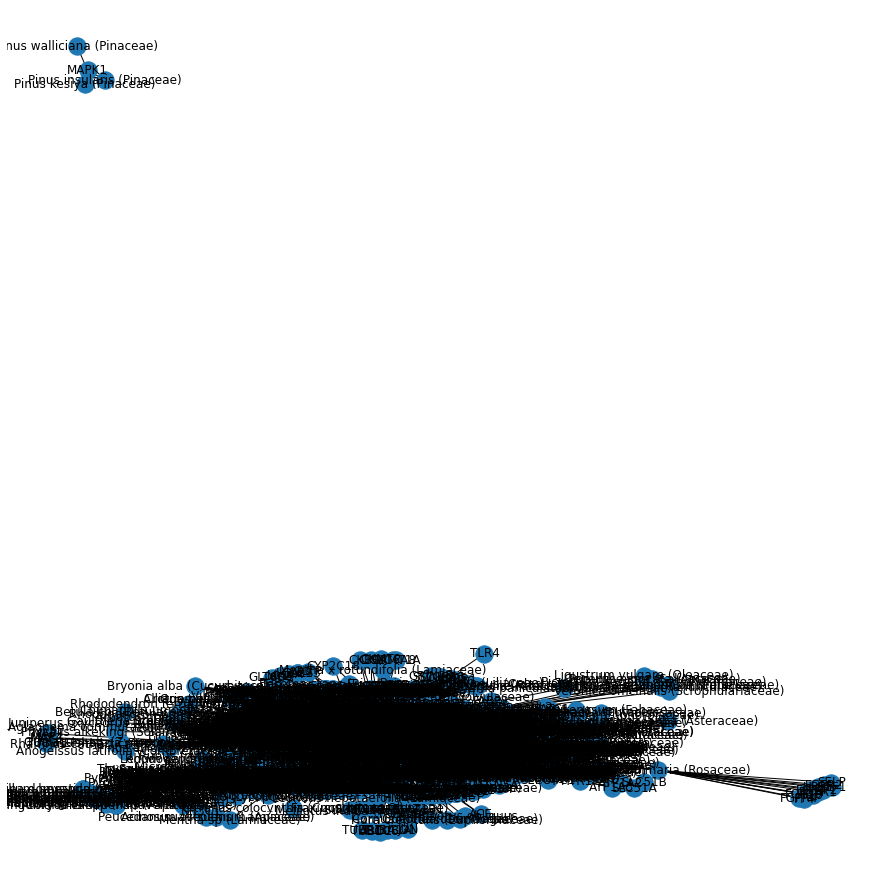

In [ ]:
PrintBold("Gene-Plant Graph")
DrawGraph(genePlantGraph)

In [ ]:
# Get Degree Centralities of Graphs
PrintBold("Gene-SMD Graph Degree Centrality for all Genes")
print(dcGeneSMD)

print()

PrintBold("Gene-Plant Graph Degree Centrality for all Genes")
print(dcGenePlant)

 Gene-SMD Graph Degree Centrality for all Genes 
[('CYP3A4', 37), ('ALB', 26), ('ABCB1', 21), ('CYP2C9', 17), ('CYP2E1', 16), ('SLC22A2', 15), ('CYP2D6', 15), ('CYP1A1', 15), ('SLC22A1', 14), ('CYP1A2', 14), ('CYP2C8', 12), ('SLC22A5', 11), ('SLC16A10', 11), ('CYP1B1', 11), ('SLCO1B1', 11), ('CYP3A5', 11), ('CYP2C19', 10), ('SLC22A3', 9), ('CYP3A7', 9), ('CYP2B6', 9), ('ESR1', 8), ('ABCB11', 8), ('ABCG2', 8), ('SLCO1A2', 7), ('ADRA1A', 7), ('GLRA1', 7), ('SLC22A8', 7), ('SLC18A2', 7), ('SLCO1B3', 7), ('BCHE', 6), ('MAOA', 6), ('CHRNA4', 6), ('CHRM2', 6), ('ABCC1', 6), ('ABCC2', 6), ('CHRM1', 6), ('ADRA2A', 6), ('SLC22A4', 6), ('SHBG', 6), ('CYP19A1', 5), ('AR', 5), ('CHRNA7', 5), ('ESR2', 5), ('CHRM4', 5), ('CHRNB2', 5), ('HTR1A', 5), ('SLC6A2', 5), ('CHRM3', 5), ('TF', 5), ('ADRB1', 4), ('HTR3A', 4), ('ACHE', 4), ('ADRB2', 4), ('GSS', 4), ('CP', 4), ('ADRA2C', 4), ('SOD1', 4), ('OPRK1', 4), ('CYP2A6', 4), ('ADORA1', 4), ('HTR2A', 4), ('OPRM1', 4), ('SLCO2B1', 4), ('OPRD1', 4), ('TRPV1

In [ ]:
# Get Weighted Degree Centralities of Graphs
PrintBold("Gene-SMD Graph Weighted Degree Centrality for all Genes")
print(wdcGeneSMD)

print()

PrintBold("Gene-Plant Graph Weighted Degree Centrality for all Genes")
print(wdcGenePlant)

 Gene-SMD Graph Weighted Degree Centrality for all Genes 
[('CYP3A4', 37), ('ALB', 26), ('ABCB1', 21), ('CYP2C9', 17), ('CYP2E1', 16), ('CYP2D6', 16), ('SLC22A2', 15), ('CYP1A1', 15), ('SLC22A1', 14), ('CYP1A2', 14), ('CYP2C8', 12), ('CYP3A5', 12), ('SLC22A5', 11), ('SLC16A10', 11), ('CYP1B1', 11), ('SLCO1B1', 11), ('CYP2C19', 10), ('SLC22A3', 9), ('CYP3A7', 9), ('CYP2B6', 9), ('ESR1', 8), ('ABCB11', 8), ('ABCG2', 8), ('SLCO1A2', 7), ('ADRA1A', 7), ('GLRA1', 7), ('SLC22A8', 7), ('SLC18A2', 7), ('SLCO1B3', 7), ('BCHE', 6), ('MAOA', 6), ('CHRNA4', 6), ('CHRM2', 6), ('ABCC1', 6), ('ABCC2', 6), ('CHRM1', 6), ('SLC6A2', 6), ('ADRA2A', 6), ('SLC22A4', 6), ('SHBG', 6), ('CYP19A1', 5), ('AR', 5), ('CHRNA7', 5), ('ESR2', 5), ('CHRM4', 5), ('SLC6A3', 5), ('CHRNB2', 5), ('ATP1A1', 5), ('HTR1A', 5), ('CHRM3', 5), ('TF', 5), ('ADRB1', 4), ('HTR3A', 4), ('ACHE', 4), ('ADRB2', 4), ('GSS', 4), ('CP', 4), ('ADRA2C', 4), ('SOD1', 4), ('OPRK1', 4), ('CYP2A6', 4), ('ADORA1', 4), ('HTR2A', 4), ('OPRM1', 4)

 CYP3A4 is associated with 37 SMD/s 


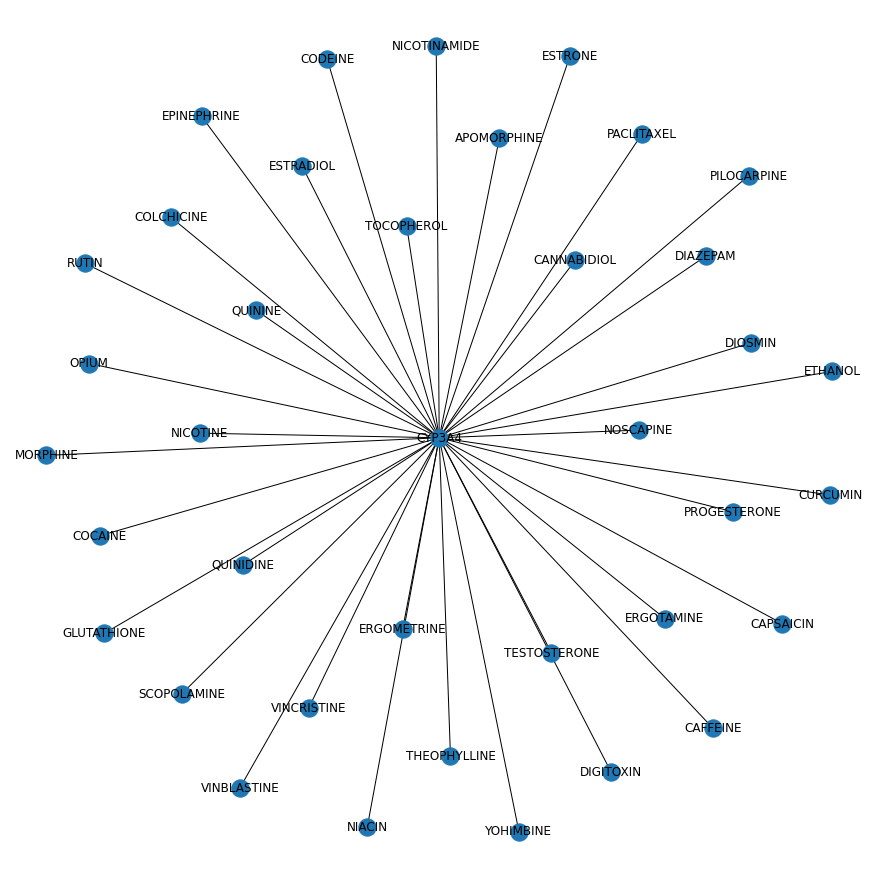

 ALB is associated with 26 SMD/s 


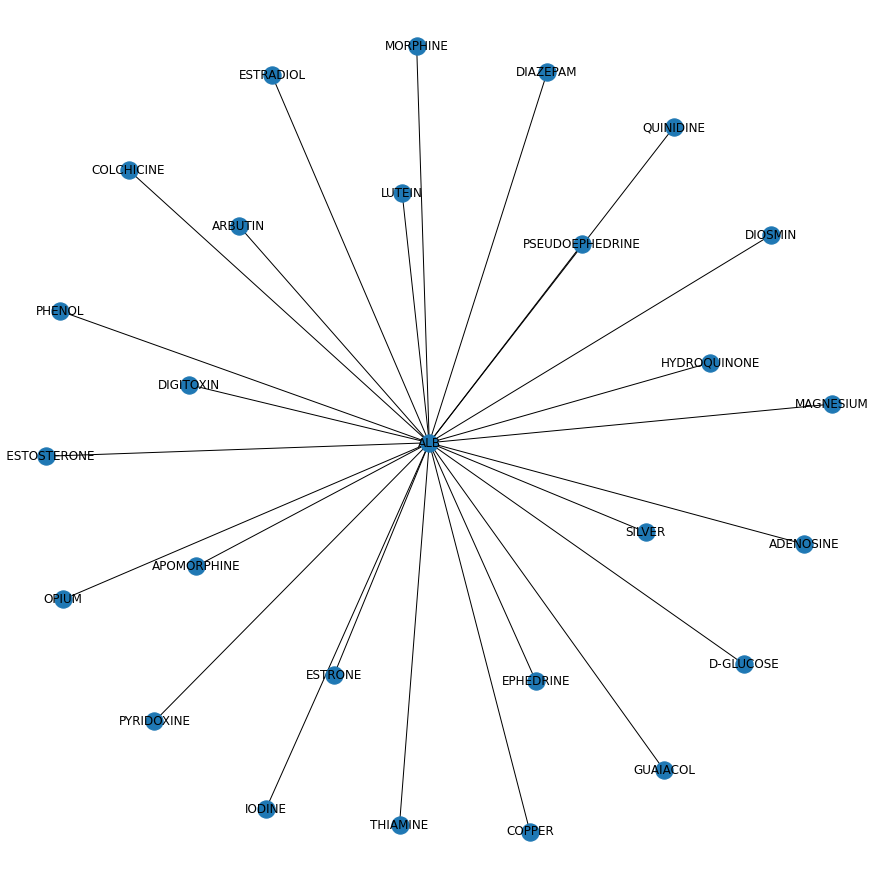

 CYP3A4 is associated with 618 Plant/s 


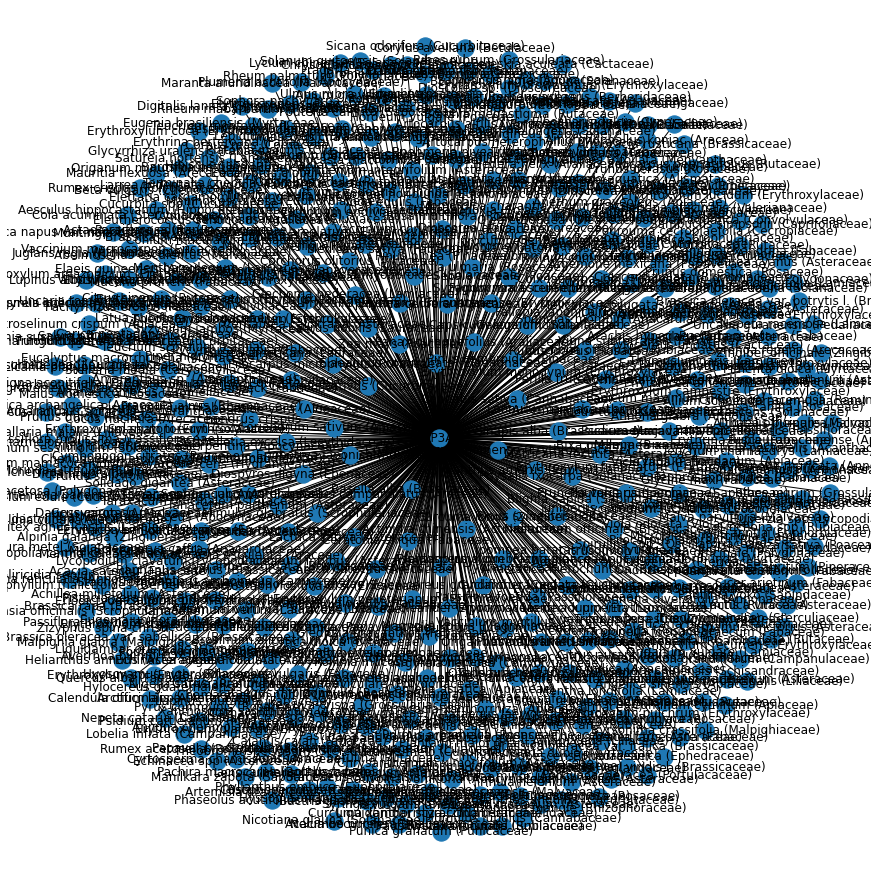

 ALB is associated with 685 Plant/s 


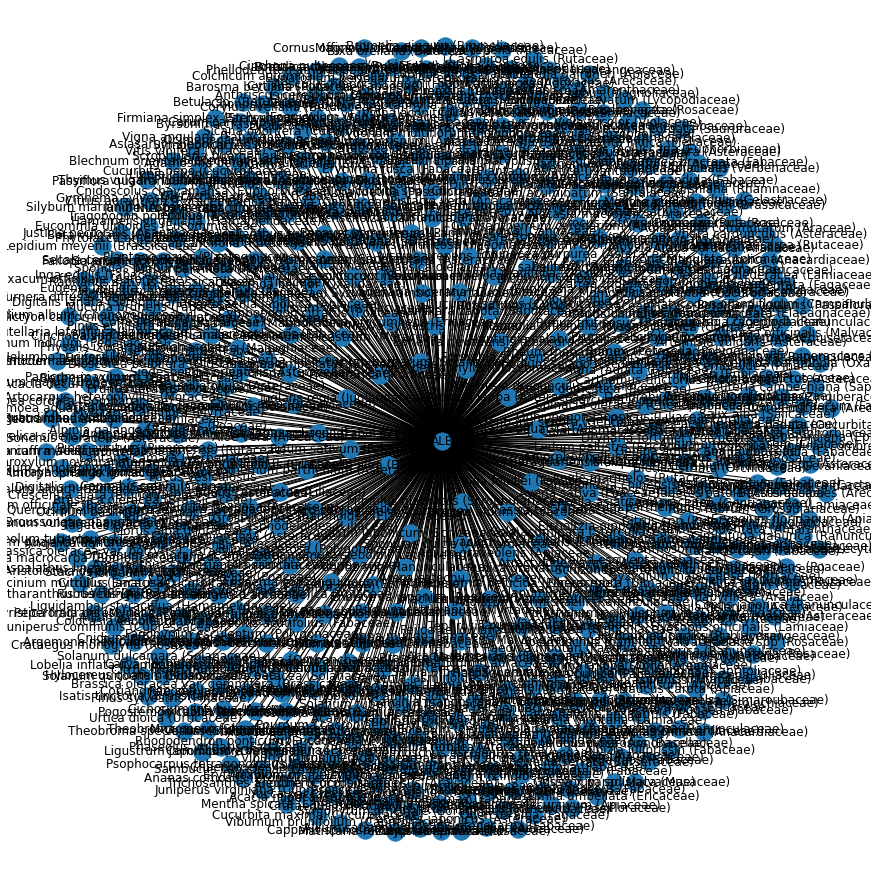

In [ ]:
# Print graph of the associated SMD/s based on a particular gene
DisplayAssociationsFromGene(geneSMDGraph, 'SMD', 'CYP3A4')
DisplayAssociationsFromGene(geneSMDGraph, 'SMD', 'ALB')

# Print graph of the associated plants/s based on a particular gene
DisplayAssociationsFromGene(genePlantGraph, 'Plant', 'CYP3A4')
DisplayAssociationsFromGene(genePlantGraph, 'Plant', 'ALB')


#**SOM ?**

In [ ]:
!pip install sklearn-som
!pip install minisom

  Created wheel for minisom: filename=MiniSom-2.2.9-cp37-none-any.whl size=8595 sha256=7e846ea418416f63c73898f8c5ddcf7db80a38ca9dbbfa596ed64ca83adecca1
  Stored in directory: /root/.cache/pip/wheels/de/a0/08/5234d6b02b29c561f62b6c985e2eb7d480fb0b92359a8c74e4
Successfully built minisom


In [ ]:
from sklearn_som.som import SOM
from minisom import MiniSom    
from matplotlib.gridspec import GridSpec
from sklearn.preprocessing import minmax_scale, scale

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# MAY SHOW ERROR BC OF DIFFERENT PATH FOR THE CSV FILE
#file reading for gene and smd
df = pd.read_csv('/content/drive/MyDrive/Copy of HI 193.1 (Group 6) - Final Paper [Drive]/gene-smd-table.csv',sep=',',header=None)
df2 = df.iloc[1: , 1:]
df3 = df2.to_numpy() #minisom uses numpy arraw
df4 = df3.astype(np.float)

gene_name = df.iloc[1:, 0].values 
smd_name = df.iloc[0, 1:].values
#print(smd_name)
#print(gene_name)
df4 

FileNotFoundError: ignored

In [ ]:
##building the som

som = MiniSom(12, 12, len(df4[0]),
              neighborhood_function='gaussian', sigma=1.5,
              random_seed=1)
#initialise weights to the map
som.pca_weights_init(df4)  


In [ ]:
#training the model might take some time to finish
som.train_batch(df4, num_iteration=len(df4)*500, verbose=True) 

In [ ]:
#creates a plot of the SOM for smd and genes 
def plotSOM(c):
    if len(c) > 120:
        return gene_name[c]
    else:
        return c

gene_map = som.labels_map(df4, df.iloc[1:, 0].values)
    
plt.figure(figsize=(12, 12))
for p, genes in gene_map.items():
    genes = list(genes)
    x = p[0] + .1
    y = p[1] - .3
    for i, c in enumerate(genes):
        off_set = (i+1)/len(genes) - 0.05
        plt.text(x, y+off_set, plotSOM(c), fontsize=7)
plt.pcolor(som.distance_map().T, cmap='seismic', alpha=.2)
plt.xticks(np.arange(12+1))
plt.yticks(np.arange(12+1))
plt.grid()

#legend_elements = [Patch(facecolor=clr,
#                         edgecolor='w',
#                         label=l) for l, clr in cmap='Greys']

plt.show()

In [ ]:
# MAY SHOW ERROR BC OF DIFFERENT PATH FOR THE CSV FILE
#file reading for plant and smd
dfp = pd.read_csv('/content/drive/MyDrive/Copy of HI 193.1 (Group 6) - Final Paper [Drive]/gene-plant-table.csv',sep=',',header=None)
dfp

In [ ]:
dfp2 = dfp.iloc[1: , 1:]
dfp3 = dfp2.to_numpy()
dfp4 = dfp3.astype(np.float)

gene_name = dfp.iloc[1:, 0].values
plant_name = dfp.iloc[0, 1:].values
print(plant_name)
print(gene_name)
dfp4

In [ ]:
som = MiniSom(15, 15, len(dfp4[0]),
              neighborhood_function='gaussian', sigma=1.5,
              random_seed=1)
som.pca_weights_init(dfp4)
som.train_batch(dfp4, num_iteration=len(dfp4)*500, verbose=True) #this will take some time to finish

In [ ]:
#creates a plot for plant and smd SOM
def plotSOM2(c):
    if len(c) > 1064:
        return gene_name[c]
    else:
        return c

gene_map = som.labels_map(dfp4, dfp.iloc[1:, 0].values)
    
plt.figure(figsize=(15, 15))
for p, genes in gene_map.items():
    genes = list(genes)
    x = p[0] + .1
    y = p[1] - .3
    for i, c in enumerate(genes):
        off_set = (i+1)/len(genes) - 0.05
        plt.text(x, y+off_set, plotSOM2(c), fontsize=7)
plt.pcolor(som.distance_map().T, cmap='seismic', alpha=.2)
plt.xticks(np.arange(15+1))
plt.yticks(np.arange(15+1))
plt.grid()

#legend_elements = [Patch(facecolor=clr,
#                         edgecolor='w',
#                         label=l) for l, clr in cmap='Greys']

plt.show()